## 1. Upload the data nd libraries

### 1.1 Imports necessary libraries

In [327]:
# Python
import pickle
import random

# Third party
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.iolib.table import SimpleTable
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Local imports
from _csv_utils import data_timeplace, DataPathCleaningManager

### 1.2 Import the data

In [328]:

data_path_manager = DataPathCleaningManager(data_timeplace)
df = data_path_manager._load_cleaned_df(domain="combined")

In [329]:
# choose relevant columns
df.columns.tolist()

[('listing', 'link'),
 ('listing', 'title'),
 ('listing', 'summary_description'),
 ('listing', 'remote_service'),
 ('pricing', 'price'),
 ('pricing', 'rent'),
 ('pricing', 'total_rent'),
 ('pricing', 'total_rent_sqm'),
 ('pricing', 'deposit'),
 ('pricing', 'deposit_ratio'),
 ('location', 'complete_address'),
 ('location', 'street'),
 ('location', 'city'),
 ('location', 'voivodeship'),
 ('size', 'square_meters'),
 ('size', 'number_of_rooms'),
 ('size', 'floor'),
 ('size', 'attic'),
 ('size', 'building_floors'),
 ('legal_and_availability', 'available_from'),
 ('legal_and_availability', 'completion'),
 ('legal_and_availability', 'ownership'),
 ('legal_and_availability', 'rent_to_students'),
 ('type_and_year', 'building_type'),
 ('type_and_year', 'build_year'),
 ('amenities', 'elevator'),
 ('amenities', 'parking_space'),
 ('equipment', 'no_information'),
 ('equipment', 'stove'),
 ('equipment', 'fridge'),
 ('equipment', 'furniture'),
 ('equipment', 'oven'),
 ('equipment', 'washing_machine')

### 1.3 Remove outliers
In our scenario, it's not necessary to have a model that perfectly aligns with every specific local case. Instead, we need a model that is well-suited for our case the average situation.

In [330]:
def filter_row(row):
    try:
        city = row['location']['city']
        building_type = row['type_and_year']['building_type'] if pd.notna(row['type_and_year'].get('building_type')) else False
        build_year = row['type_and_year']['build_year'] if pd.notna(row['type_and_year'].get('build_year')) else False
        return city in ["będziński", "Zawada", "Siewierz", "tarnogórski", "Piekary Śląskie", "zawierciański", "Siemianowice Śląskie"] \
        and building_type in ["block_of_flats", "apartment_building"] \
        and build_year <= 1970
    except KeyError:
        return False

narrowed_df = df[df.apply(filter_row, axis=1)].copy()

In [331]:
df_outliers_filtered = narrowed_df[df[('pricing', 'total_rent')] < 4000]

C:\Users\karol\AppData\Local\Temp\ipykernel_21364\1265486152.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_outliers_filtered = narrowed_df[df[('pricing', 'total_rent')] < 4000]


### 1.4 Select relevant data

It's an iterative process. During the exploration of data through the various models you will find out which one works and not.

In [332]:
# relevant but multicollinearity:
# level 1 - very high
# level 2 - high

df_model = pd.DataFrame()

columns_to_select = [
    ('pricing', 'total_rent'),
    # ('location', 'city'),
    ('size', 'square_meters'),
    # ('size', 'number_of_rooms'), # level 1
    ('type_and_year', 'building_type'),
    ('type_and_year', 'build_year'),
    ('amenities', 'elevator'),
    # ('amenities', 'parking_space'),
    # ('equipment', 'furniture'), # level 1
    # ('equipment', 'stove'), # level 1
    # ('equipment', 'oven'),
    ('equipment', 'washing_machine'),
    # ('equipment', 'TV'),
    # ('equipment', 'dishwasher'),
    # ('media_types', 'internet'), # level 2
    # ('media_types', 'cable_TV'), # level 2
    # ('heating', 'district'),
    # ('security', 'monitoring_or_security'),
    # ('security', 'anti_burglary_doors_or_windows'), # level 2
    # ('security', 'enclosed_area'), # level 2
    # ('windows', 'aluminum'),
    ('size', 'floor'),
    # ('size', 'building_floors'), # level 1
    # ('additional_information', 'air_conditioning'),
    # ('additional_information', 'utility_room'),
]

extracted_columns = df_outliers_filtered.loc[:, columns_to_select]


extracted_columns.columns = extracted_columns.columns.droplevel(0)


df_model[extracted_columns.columns] = extracted_columns

In [333]:
df_model.dtypes

total_rent         float64
square_meters        Int64
building_type       string
build_year         float64
elevator              bool
washing_machine       bool
floor                Int64
dtype: object

## 2. Get dummy data

Transforms categorical variables into numerical form by creating binary (`True`/`False`) indicator variables for each category, resulting in a new DataFrame called `df_dum`

In [334]:
df_dum = pd.get_dummies(df_model)

In [335]:
df_dum.dtypes

total_rent                          float64
square_meters                         Int64
build_year                          float64
elevator                               bool
washing_machine                        bool
floor                                 Int64
building_type_apartment_building      uint8
building_type_block_of_flats          uint8
dtype: object

## 3. Training and Testing Data Separation
This step divides our data into two groups: one for training our model (learning from examples) and the other for testing it (checking how well it learned). We use a tool called `train_test_split` for this division, ensuring that our model can be trained on one part of the data and then evaluated on a different part to see how well it predicts new, unseen information.

In [336]:
# Splitting the dataset into features (X) and target variable (Y), where 'total_rent' is the target.
X = df_dum.drop('total_rent', axis =1)
Y = df_dum['total_rent']

# Converting boolean columns to integers for model compatibility. Models typically require numerical input.
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Replacing infinite values with NaN in the features to avoid errors during model training.
X = X.replace([np.inf, -np.inf], np.nan)

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the imputer to the feature set. Note: It's important to do this before the train-test split.
X_imputed = knn_imputer.fit_transform(X)
X_imputed = X_imputed.astype(float)

# Now, handle the target variable
Y = Y.replace([np.inf, -np.inf], np.nan)
Y = Y.fillna(0)

# Splitting the dataset into training and testing sets for model validation.
X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y.values, test_size=0.2, random_state=42)

In [337]:
my_xnames = pd.Index(['total_rent'] + X.columns.tolist())

## 4. Multiple Linear Regression
This section implements a Multiple Linear Regression model using the Ordinary Least Squares (OLS) method from the statsmodels library. In this approach, the model aims to establish a linear relationship between multiple independent variables (features) and a single dependent variable (target). The OLS method is employed to determine the line of best fit, which is achieved by minimizing the sum of the squares of the residuals - the differences between the observed values and the values predicted by the model. This process allows for an efficient and effective way to understand how each independent variable contributes to the dependent variable, facilitating predictions and insights into the underlying data relationships.

In [338]:
# Y_train = Y_train.astype(float)

# Adding a constant to the feature set and constructing the OLS model
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train_sm)

# You can name the variables in your model for better readability
# Assuming 'my_xnames' is defined and includes the names of your features
model.data.xnames = ['Intercept'] + X.columns.tolist()

In [339]:
results = model.fit().summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     6.508
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           0.000277
Time:                        21:16:28   Log-Likelihood:                -240.32
No. Observations:                  33   AIC:                             494.6
Df Residuals:                      26   BIC:                             505.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                        -2.293e+04   1.65e+04     -1.392      0.176   -5.68e+04    1.09e+04
square_meters                       22.5831      5.807      3.889      0.001      10.646      34.520
build_year                          17.9687     12.585      1.428      0.165      -7.899      43.837
elevator                          -519.4053    301.882     -1.721      0.097   -1139.932     101.122
washing_machine                    437.9874    150.576      2.909      0.007     128.474     747.501
floor                               37.6382     43.388      0.867      0.394     -51.547     126.823
building_type_apartment_building -1.122e+04   8254.634     -1.359      0.186   -2.82e+04    5748.749
building_type_block_of_flats     -1.171e+04   8221.855     -1.425      0.166   -2.86e+04    5185.329
==============================================================================
Omnibus:                        1.684   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.431   Jarque-Bera (JB):                1.402
Skew:                          -0.490   Prob(JB):                        0.496
Kurtosis:                       2.759   Cond. No.                     6.69e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.84e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

C:\Users\karol\AppData\Local\Temp\ipykernel_21364\3920633229.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_model.corr()


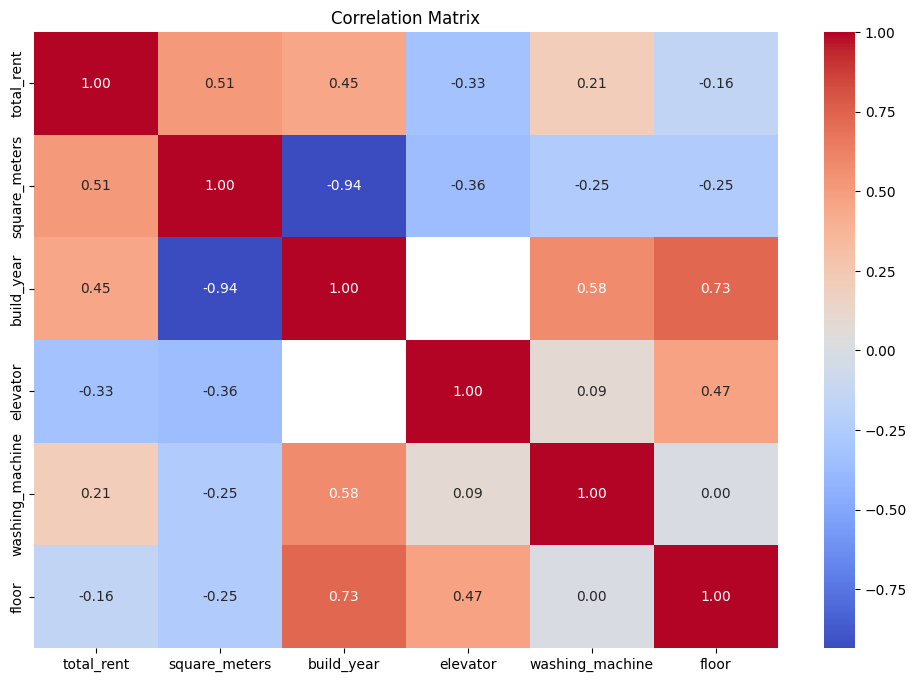

In [340]:
corr_matrix = df_model.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

This heatmap is a correlation matrix displaying how closely the variables in our dataset are related to each other.<br>
It's used here to detect multicollinearity, where some features might be too similar, providing overlapping information.<br>
We're looking for highly correlated features (close to 1 or -1) to consider removing them, reducing multicollinearity,<br>
and improving our model's reliability.


In [341]:
def get_t_results(results, t_cap):
    table_index = 1

    table_data = results.tables[table_index].data

    filtered_data = [row for row in table_data if float(row[-2].replace("[", "")) >= t_cap]

    sorted_data = sorted(filtered_data, key=lambda x: float(x[-2].replace("[", "")), reverse=True)

    filtered_table = SimpleTable(sorted_data, title=results.tables[table_index].title)

    print(f"passed_t_variables: {len(filtered_data)}")
    print(f"variables: {len(table_data)}")
    print(f"percentage: {round((len(filtered_data) / len(table_data)) * 100, 2)}")
    return filtered_table

get_t_results(results, 0.05)

passed_t_variables: 2
variables: 9
percentage: 22.22


washing_machine,437.9874,150.576,2.909,0.007,128.474,747.501
square_meters,22.5831,5.807,3.889,0.001,10.646,34.520


In [342]:
lm = LinearRegression()
lm.fit(X_train, Y_train)

np.mean(cross_val_score(lm,X_train,Y_train, scoring = 'neg_mean_absolute_error', cv=10))

-358.1956739885619

## 5. Simplifying the Model with Lasso Regression
In this step, we use a technique called Lasso regression, which helps us simplify our prediction model.<br>
Think of Lasso as a sculptor who chisels away the less important parts of a statue; similarly, Lasso reduces the impact of less important information when making predictions.<br>
We try out different levels of simplification, which in Lasso are called `alpha values`, and for each level, we measure how far off our predictions are from the actual numbers using something called the mean absolute error.<br>
Our goal is to find the right balance where the model is simple but still makes accurate predictions.

In [343]:
lm_l = Lasso(alpha=.99)
lm_l.fit(X_train,Y_train)
avg_score = np.mean(cross_val_score(lm_l,X_train,Y_train, scoring = 'neg_mean_absolute_error', cv= 10))
avg_score

-356.52042366621606

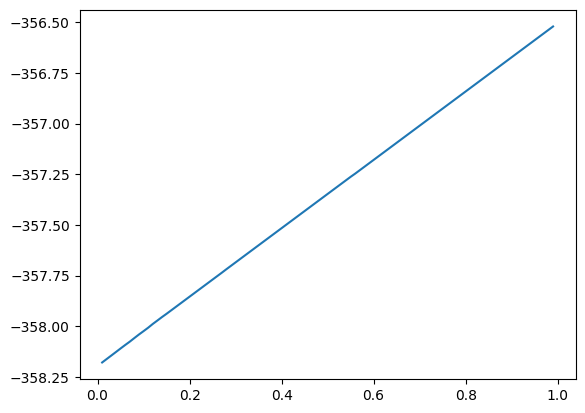

Best alpha: 0.99


In [344]:
alpha = []
error = []

# Loop to populate alpha and error lists
for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml, X_train, Y_train, scoring='neg_mean_absolute_error', cv=10)))

# Plotting
plt.plot(alpha, error)
plt.show()

# Finding the best alpha
best_alpha_index = np.argmax(error)  # Get the index of the best error
best_alpha = alpha[best_alpha_index]  # Use index to find the corresponding alpha
print(f"Best alpha: {best_alpha}")


## 6. Building a Decision-Making Forest
Here, we embark on constructing a 'Random Forest'—an assembly of decision trees working together to make more accurate predictions than any single tree could alone. Imagine a random forest as a team of experts where each member brings their own perspective; they debate and combine their knowledge to arrive at the best possible decision. Our random forest model, known as 'rf', learns from different parts of our data and then aggregates this learning to predict values like rental prices. To gauge how well our random forest is performing, we use a method called cross-validation, which is like a series of practice runs. It splits our data into smaller sections, trains the forest on some sections, and tests it on others, over and over. After these practice runs, we calculate the 'mean absolute error'—an average of how much our forest's predictions deviate from the actual prices. Lower error means our forest is wise and its predictions are close to reality.

In [345]:
rf = RandomForestRegressor()

np.mean(cross_val_score(rf,X_train,Y_train,scoring = 'neg_mean_absolute_error', cv= 15))

-380.28222222222223

## 7. Optimizing Model Parameters with GridSearchCV
This section is dedicated to refining the performance of our Random Forest model by adjusting its hyperparameters—the settings that dictate the model's learning behavior. We employ a method known as GridSearchCV, which stands for Grid Search with Cross-Validation. This technique systematically explores a range of values for different hyperparameters, such as 'n_estimators,' which determines the number of decision trees in our forest; 'criterion,' which sets the measure of quality for a split in the trees; and 'max_features,' which specifies the maximum number of features the model considers when making a split.

GridSearchCV conducts a thorough search across a predefined grid of hyperparameter values, evaluating the model's performance for each combination through cross-validation. Cross-validation is a robust assessment technique that divides the data into subsets, uses some for training and some for evaluation, and then rotates these roles to average out the model's predictive accuracy.

The process aims to identify the optimal combination of hyperparameters that minimizes the mean absolute error—a metric that quantifies the average magnitude of errors in the model's predictions, disregarding their direction.

In [346]:
parameters = {'n_estimators':range(10,300,10), 'criterion':('friedman_mse','absolute_error', 'poisson', 'squared_error'), 'max_features':('auto','sqrt','log2')}

# gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=10)
# gs.fit(X_train,Y_train)

# gs.best_score_
# gs.best_estimator_

In [347]:
# test ensembles 
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
# tpred_rf = gs.best_estimator_.predict(X_test)

print(f"tpred_lm: {mean_absolute_error(Y_test,tpred_lm)}")
print(f"tpred_lml: {mean_absolute_error(Y_test,tpred_lml)}")
# print(f"tpred_rf: {mean_absolute_error(Y_test,tpred_rf)}")

# print(f"tpred_lm + tpred_rf: {mean_absolute_error(Y_test,(tpred_lm+tpred_rf)/2)}")
print(f"tpred_lm + tpred_lml: {mean_absolute_error(Y_test,(tpred_lm+tpred_lml)/2)}")
# print(f"tpred_rf + tpred_lml: {mean_absolute_error(Y_test,(tpred_lml+tpred_rf)/2)}")

tpred_lm: 298.4350320745911
tpred_lml: 298.09065497671287
tpred_lm + tpred_lml: 298.262843525652


## 8. Other models
The Gradient Boosting Regressor (`GBM`), Support Vector Machine Regressor (`SVM`), and Decision Tree Regressor (`DT`) are three distinct machine learning models initialized and trained on our dataset to predict rental prices.<br>
The `GBM` model, known for its predictive accuracy by combining multiple weak learners,<br>
the `SVM` that excels in high-dimensional spaces,<br>
and the `DT` breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed,<br>
all exhibit varied approaches to the regression task.<br>
After being trained, each model's performance is evaluated using the Mean Absolute Error (`MAE`) metric on a set of test data, providing a straightforward comparison of their predictive capabilities.

### 8.1 Testing other models

In [348]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Initialize the new models
gbm = GradientBoostingRegressor()
svm = SVR()
dt = DecisionTreeRegressor()

# Fit the models to the training data
gbm.fit(X_train, Y_train)
svm.fit(X_train, Y_train)
dt.fit(X_train, Y_train)

# Make predictions
tpred_gbm = gbm.predict(X_test)
tpred_svm = svm.predict(X_test)
tpred_dt = dt.predict(X_test)

# Print MAE for each model
print(f"tpred_gbm: {mean_absolute_error(Y_test, tpred_gbm)}")
print(f"tpred_svm: {mean_absolute_error(Y_test, tpred_svm)}")
print(f"tpred_dt: {mean_absolute_error(Y_test, tpred_dt)}")

# Ensemble predictions with new models
print(f"tpred_lm + tpred_gbm: {mean_absolute_error(Y_test, (tpred_lm+tpred_gbm)/2)}")
# print(f"tpred_rf + tpred_svm: {mean_absolute_error(Y_test, (tpred_rf+tpred_svm)/2)}")
print(f"tpred_lml + tpred_dt: {mean_absolute_error(Y_test, (tpred_lml+tpred_dt)/2)}")

tpred_gbm: 503.8079290154982
tpred_svm: 300.66649116111665
tpred_dt: 546.4444444444445
tpred_lm + tpred_gbm: 401.1214805450447
tpred_lml + tpred_dt: 365.0755804886519


### 8.2 Fine tuning selected model
`Grid Search` and `Randomized Search`, to optimize the `hyperparameters` of a `Gradient Boosting Regressor` model, aiming to find the configuration that minimizes prediction error as measured by the Mean Absolute Error (`MAE`).

#### 8.2.1 Grid Search Cross-Validation

In [349]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    # Add other parameters here
}

grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, Y_train)
gsc_best_params = grid_search.best_params_

#### 8.2.2 Randomized Search Cross-Validation

In [350]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {
    'n_estimators': sp_randint(100, 500),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': sp_randint(3, 10),
    # 'min_samples_split': sp_randint(2, 10),
    # 'min_samples_leaf': sp_randint(1, 10),
    # 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    # 'max_features': ['auto', 'sqrt', 'log2', None],
    # 'loss': ['absolute_error', 'quantile', 'squared_error', 'huber'],
    # 'criterion': ['friedman_mse', 'squared_error']
}

n_iter_search = 20
random_search = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_absolute_error')
random_search.fit(X_train, Y_train)
rsc_best_params = random_search.best_params_


#### 8.2.3 Evaluating the params

In [351]:
# Using the best parameters from Grid Search to create and fit the model
gbm_grid = GradientBoostingRegressor(**gsc_best_params)
gbm_grid.fit(X_train, Y_train)
tpred_gbm_grid = gbm_grid.predict(X_test)
mae_gbm_grid = mean_absolute_error(Y_test, tpred_gbm_grid)
print(f"MAE for Grid Search model: {mae_gbm_grid}")

# Using the best parameters from Randomized Search to create and fit the model
gbm_random = GradientBoostingRegressor(**rsc_best_params)
gbm_random.fit(X_train, Y_train)
tpred_gbm_random = gbm_random.predict(X_test)
mae_gbm_random = mean_absolute_error(Y_test, tpred_gbm_random)
print(f"MAE for Randomized Search model: {mae_gbm_random}")

MAE for Grid Search model: 317.6106303250012
MAE for Randomized Search model: 372.99619838626154


## 9. Save model and validate it on selected sample

In [352]:
def save_dataframe_metadata(df, file_path):
    """
    Save the column names, data types, and column order of any DataFrame to a JSON file.

    Args:
    df (pandas.DataFrame): The DataFrame from which to save metadata.
    file_path (str): Path to save the JSON file containing the metadata.
    """
    metadata = {
        'columns': {col: str(df[col].dtype) for col in df.columns},
        'column_order': list(df.columns)
    }

    with open(file_path, 'w') as file:
        json.dump(metadata, file, indent=4)

In [373]:
# Assuming 'svm' is the model you want to save
pickl = {'model': svm}

# Saving the model to a file
pickle.dump(pickl, open('svm_model_file.p', 'wb'))

In [374]:
file_name = "svm_model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data.get('model')

In [375]:
# Check if model is loaded correctly
if hasattr(model, 'predict'):
    # Assuming X_test is defined and valid
    random_sample = X_test[random.randint(0, X_test.shape[0]-1)]  # Use shape[0] for the number of rows
    prediction = model.predict(random_sample.reshape(1, -1))
    print("Prediction:", prediction)
else:
    print("Loaded data is not a model or does not have a predict method.")

Prediction: [1900.99914035]


In [376]:
# Save df_dum's X axis data structure to 'gbm_model_metadata.json'
# to ensure the other non-training data matches the model's training format.
save_dataframe_metadata(X, 'svm_model_metadata.json')

In [377]:
random_sample = X_test[random.randint(0, X_test.shape[1])]

In [378]:
random_sample

array([6.00e+01, 1.96e+03, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
       1.00e+00])

In [379]:
model.predict(random_sample.reshape(1, -1))

array([1901.00217267])

In [380]:
list(random_sample)

[60.0, 1960.0, 0.0, 1.0, 0.0, 0.0, 1.0]